In [42]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors


import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from collections import Counter

from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

from sklearn.linear_model import LogisticRegression

# Pre-Processing

### SQL Injection dataset

In [2]:
df = pd.read_csv('./data/sql_injection_raw.csv',encoding='utf-16') 
#source: https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset

In [3]:
df = df.dropna()

In [4]:
# Get unique values existing in the label column to check if need to clean that

df['Label'].value_counts()

Label
0    22304
1    11453
Name: count, dtype: int64

In [5]:
df.Label.dtype #making sure that Label is int

dtype('int64')

In [6]:
df.rename(columns={'Sentence': 'query', 'Label': 'label'}, inplace=True)

In [7]:
df.head()

,query,label
1,""" or pg_sleep ( __TIME__ ) --",1
2,create user name identified by pass123 tempora...,1
3,%29,1
4,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
5,select * from users where id = '1' or @ @1 = ...,1


In [8]:
df.describe()

,label
count,33757.000000
mean,0.339278
std,0.473471
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
# Separate the DataFrame into two based on the label
df_label_1 = df[df['label'] == 1]
df_label_0 = df[df['label'] == 0]

# Randomly sample 4K rows from each
df_label_1_sampled = df_label_1.sample(n=4000, random_state=1)
df_label_0_sampled = df_label_0.sample(n=4000, random_state=1)

# Combine the samples into one DataFrame
df_sampled = pd.concat([df_label_1_sampled, df_label_0_sampled])

# Shuffle the combined DataFrame
df = df_sampled.sample(frac=1, random_state=1).reset_index(drop=True)

In [10]:
df.describe()

,label
count,8000.000000
mean,0.500000
std,0.500031
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [11]:
df['label'].value_counts()

label
0    4000
1    4000
Name: count, dtype: int64

In [12]:
df_injection = df

### Query Execution Time Dataset

In [13]:
df_processing_time = pd.read_csv('./data/queries_with_processing_times.csv')
# Generated the data by ourselves

In [14]:
df_processing_time.isna().sum()

query                0
processing_time    203
dtype: int64

In [15]:
df_processing_time = df_processing_time.dropna()

In [16]:
df_processing_time.isna().sum()

query              0
processing_time    0
dtype: int64

In [17]:
df_processing_time['query'] = df_processing_time['query'].str.strip()

In [18]:
df_processing_time.head()

,query,processing_time
0,SELECT * FROM Products WHERE Price > 500;,1.666016
1,SELECT * FROM Customers WHERE LastName LIKE 'S%';,0.591064
2,"SELECT OrderID, CustomerID FROM Orders WHERE O...",0.555908
3,"SELECT ProductName, Stock FROM Products WHERE ...",0.737061
4,SELECT COUNT(*) FROM Orders WHERE TotalAmount ...,0.500000


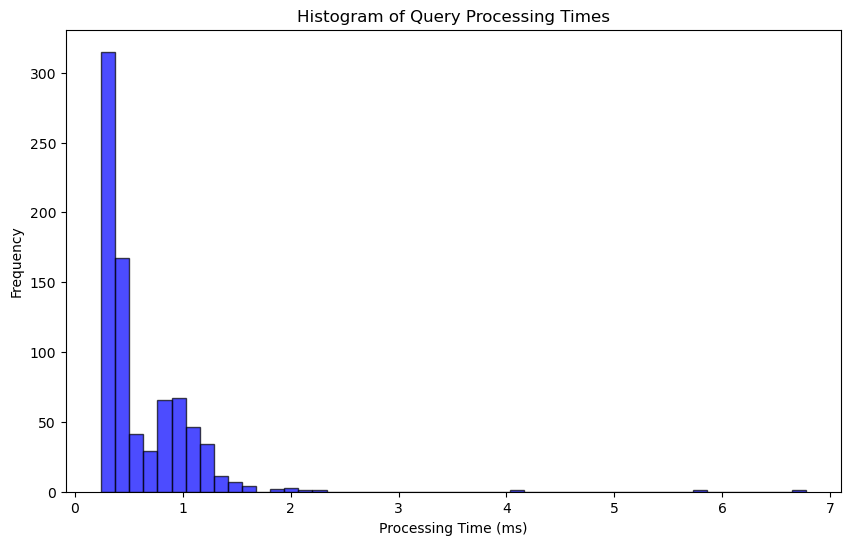

In [19]:
# Create a histogram of processing times
plt.figure(figsize=(10, 6))
plt.hist(df_processing_time['processing_time'], bins=50, color='blue', alpha=0.7, edgecolor='black')

# Add title and labels
plt.title('Histogram of Query Processing Times')
plt.xlabel('Processing Time (ms)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [20]:
#data doesnt follow gaussian distriubution 
#so we will use We'll set the threshold based on the 95th percentile of the data
#Top 5% of the processing times will be considered as anomalies.

threshold = df_processing_time['processing_time'].quantile(0.95)

In [21]:
# Label queries as anomalies if their processing time is above the threshold
df_processing_time['label'] = df_processing_time['processing_time'].apply(lambda x: 1 if x > threshold else 0)

In [22]:
df_processing_time.head()

,query,processing_time,label
0,SELECT * FROM Products WHERE Price > 500;,1.666016,1
1,SELECT * FROM Customers WHERE LastName LIKE 'S%';,0.591064,0
2,"SELECT OrderID, CustomerID FROM Orders WHERE O...",0.555908,0
3,"SELECT ProductName, Stock FROM Products WHERE ...",0.737061,0
4,SELECT COUNT(*) FROM Orders WHERE TotalAmount ...,0.500000,0


In [23]:
df_processing_time['label'].value_counts()

label
0    757
1     40
Name: count, dtype: int64

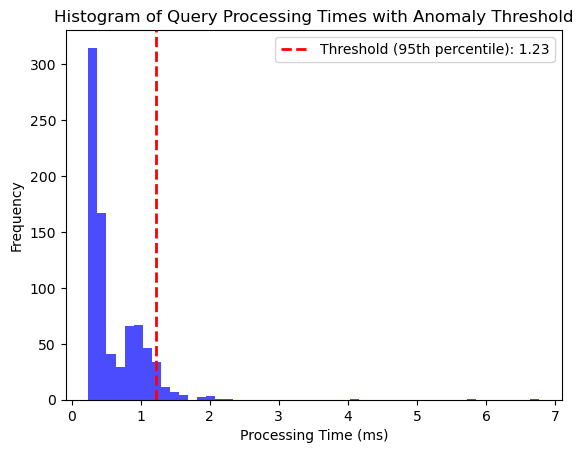

In [24]:
# Plot the histogram of processing times
plt.hist(df_processing_time['processing_time'], bins=50, color='blue', alpha=0.7)

# Add a vertical line at the threshold
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold (95th percentile): {threshold:.2f}')

# Add labels and title
plt.xlabel('Processing Time (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Query Processing Times with Anomaly Threshold')
plt.legend()

# Show the plot
plt.show()

In [25]:
df_processing_time = df_processing_time.drop(columns=['processing_time'])

In [26]:
df_processing_time.head()

,query,label
0,SELECT * FROM Products WHERE Price > 500;,1
1,SELECT * FROM Customers WHERE LastName LIKE 'S%';,0
2,"SELECT OrderID, CustomerID FROM Orders WHERE O...",0
3,"SELECT ProductName, Stock FROM Products WHERE ...",0
4,SELECT COUNT(*) FROM Orders WHERE TotalAmount ...,0


In [27]:
merged_df = pd.concat([df_injection, df_processing_time], ignore_index=True)

In [28]:
merged_df.head()

,query,label
0,42685012w,0
1,09410,0
2,sureda bahamonde,0
3,62955100y,0
4,1 ) ) and ( 3020 = 3020 ) *6703 and ( ...,1


In [29]:
merged_df.describe()

,label
count,8797.000000
mean,0.459247
std,0.498365
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# Feature Engineering

In [30]:
# Split the data into training and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df['label'])

# Further split test_df into two equal parts
ensemble_test_df, base_algo_test_df = train_test_split(test_df, test_size=0.8, random_state=42, stratify=test_df['label'])

# Perform Count Vectorization
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['query'])
X_test = vectorizer.transform(base_algo_test_df['query'])

# Convert the sparse matrix to a dense matrix to make it easier to analyze, and train on machine learning models. 
# Then convert this to a DataFrame
X_train_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
X_test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

# Base Models

### Isolation Forest

In [31]:
# Function to evaluate the model

def evaluate_model(contamination_value): 
    iso_forest = IsolationForest(contamination=contamination_value, random_state=42)
    iso_forest.fit(X_train_df)
    y_pred = iso_forest.predict(X_test_df)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(f"Contamination: {contamination_value}")
    print(classification_report(base_algo_test_df['label'], y_pred))
    print("\n")

# Test different contamination values
for contamination in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    evaluate_model(contamination)

Contamination: 0.1
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       762
           1       0.95      0.19      0.32       646

    accuracy                           0.62      1408
   macro avg       0.77      0.59      0.53      1408
weighted avg       0.75      0.62      0.55      1408



Contamination: 0.15
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       762
           1       0.89      0.27      0.42       646

    accuracy                           0.65      1408
   macro avg       0.75      0.62      0.58      1408
weighted avg       0.74      0.65      0.60      1408



Contamination: 0.2
              precision    recall  f1-score   support

           0       0.63      0.95      0.76       762
           1       0.86      0.33      0.48       646

    accuracy                           0.67      1408
   macro avg       0.74      0.64      0.62      1408
weighted avg

In [32]:
#chose 0.5 as contamination value as we prefer catching more anomalies at the risk of some false alarms
# We cannot let a anomaly go through
evaluate_model(0.5)
iso_forest = IsolationForest(contamination=0.5, random_state=42)
iso_forest.fit(X_train_df)

Contamination: 0.5
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       762
           1       0.71      0.73      0.72       646

    accuracy                           0.74      1408
   macro avg       0.74      0.74      0.74      1408
weighted avg       0.74      0.74      0.74      1408





IsolationForest(contamination=0.5, random_state=42)

In [33]:
if_f1_score = 0.72

### SVM

In [34]:
# Function to evaluate the model
def evaluate_model(nu_value):
    one_class_svm = OneClassSVM(nu=nu_value, kernel='rbf', gamma='auto')
    one_class_svm.fit(X_train_df)
    y_pred = one_class_svm.predict(X_test_df)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(f"nu: {nu_value}")
    print(classification_report(base_algo_test_df['label'], y_pred))
    print("\n")

# Test different nu values
for nu in [0.1, 0.15, 0.2, 0.25]:
    evaluate_model(nu)


nu: 0.1
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       762
           1       1.00      0.15      0.26       646

    accuracy                           0.61      1408
   macro avg       0.79      0.57      0.50      1408
weighted avg       0.77      0.61      0.52      1408



nu: 0.15
              precision    recall  f1-score   support

           0       0.59      0.98      0.74       762
           1       0.90      0.21      0.34       646

    accuracy                           0.62      1408
   macro avg       0.75      0.59      0.54      1408
weighted avg       0.73      0.62      0.55      1408



nu: 0.2
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       762
           1       0.89      0.26      0.41       646

    accuracy                           0.65      1408
   macro avg       0.75      0.62      0.58      1408
weighted avg       0.74      0.65      0.59  

In [35]:
#nu: 0.25 chosen 
svm_f1_score = 0.48
one_class_svm = OneClassSVM(nu=0.25, kernel='rbf', gamma='auto')
one_class_svm.fit(X_train_df)

OneClassSVM(gamma='auto', nu=0.25)

### random forest

In [36]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_df, train_df['label'])

# Evaluate the Random Forest model
y_pred = rf_model.predict(X_test_df)

print("Random Forest Classifier")
print(classification_report(base_algo_test_df['label'], y_pred))


Random Forest Classifier
              precision    recall  f1-score   support

           0       0.98      0.36      0.52       762
           1       0.57      0.99      0.72       646

    accuracy                           0.65      1408
   macro avg       0.77      0.67      0.62      1408
weighted avg       0.79      0.65      0.61      1408



In [37]:
rf_f1_score = 0.72

### KNN

In [38]:
y_train = train_df['label']
y_test = base_algo_test_df['label']

# Function to evaluate the KNN model
def evaluate_knn_model(n_neighbors, contamination_value):
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X_train_df)

    distances, indices = knn.kneighbors(X_test_df)
    anomaly_scores = np.mean(distances, axis=1)
    
    
    threshold = np.percentile(anomaly_scores, 100 * contamination_value)
    y_pred = (anomaly_scores >= threshold).astype(int)

    # Check if lengths match
    if len(y_pred) != len(y_test):
        print(f"Length mismatch: y_pred={len(y_pred)}, y_test={len(y_test)}")
        return

    print(f"Number of Neighbors: {n_neighbors}")
    print(f"Contamination: {contamination_value}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("\n")

# Test different values of k (number of neighbors) and contamination values
for k in [5, 10, 15, 20]:
    for contamination in [0.1, 0.15, 0.2, 0.25]:
        evaluate_knn_model(k, contamination)

Number of Neighbors: 5
Contamination: 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       762
           1       0.46      1.00      0.63       646

    accuracy                           0.46      1408
   macro avg       0.23      0.50      0.31      1408
weighted avg       0.21      0.46      0.29      1408



Number of Neighbors: 5
Contamination: 0.15
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       762
           1       0.46      1.00      0.63       646

    accuracy                           0.46      1408
   macro avg       0.23      0.50      0.31      1408
weighted avg       0.21      0.46      0.29      1408



Number of Neighbors: 5
Contamination: 0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       762
           1       0.46      1.00      0.63       646

    accuracy                           0.46      14

In [39]:
#not using this for ensemble. Not appropriate for our dataset

# Ensemble

In [43]:
# Calculate the weights based on F1 scores
sum_of_f1_scores = if_f1_score + rf_f1_score + svm_f1_score

if_weight = if_f1_score / sum_of_f1_scores
rf_weight = rf_f1_score / sum_of_f1_scores
svm_weight = svm_f1_score / sum_of_f1_scores

# Define the functions to check anomaly for each model
def is_anomaly_iso_forest(query_vec):
    prediction = iso_forest.predict(query_vec)[0]
    return 1 if prediction == -1 else 0

def is_anomaly_random_forest(query_vec):
    prediction = rf_model.predict(query_vec)[0]
    return prediction

def is_anomaly_svm(query_vec):
    prediction = one_class_svm.predict(query_vec)[0]
    return 1 if prediction == -1 else 0

# Define the ensemble function
def ensemble(query_vec):
    """
    Function to predict if a query is an anomaly using ensemble method.
    
    Parameters:
    query_vec (DataFrame): The vectorized SQL query.
    
    Returns:
    int: 1 if the query is an anomaly, 0 if it is not.
    """
    iso_pred = is_anomaly_iso_forest(query_vec)
    rf_pred = is_anomaly_random_forest(query_vec)
    svm_pred = is_anomaly_svm(query_vec)
    
    ensemble_average = if_weight * iso_pred + rf_weight * rf_pred + svm_weight * svm_pred
    return 1 if ensemble_average > 0.5 else 0

# Evaluate the ensemble model
ensemble_predictions = []
for query in ensemble_test_df['query']:
    query_vec = vectorizer.transform([query]).toarray()
    prediction = ensemble(query_vec)
    ensemble_predictions.append(prediction)

# Print classification report
print(classification_report(ensemble_test_df['label'], ensemble_predictions))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       190
           1       0.90      0.69      0.78       162

    accuracy                           0.82       352
   macro avg       0.84      0.81      0.81       352
weighted avg       0.83      0.82      0.81       352



In [45]:
ensemble_f1_score = 0.78

# Visualizing 

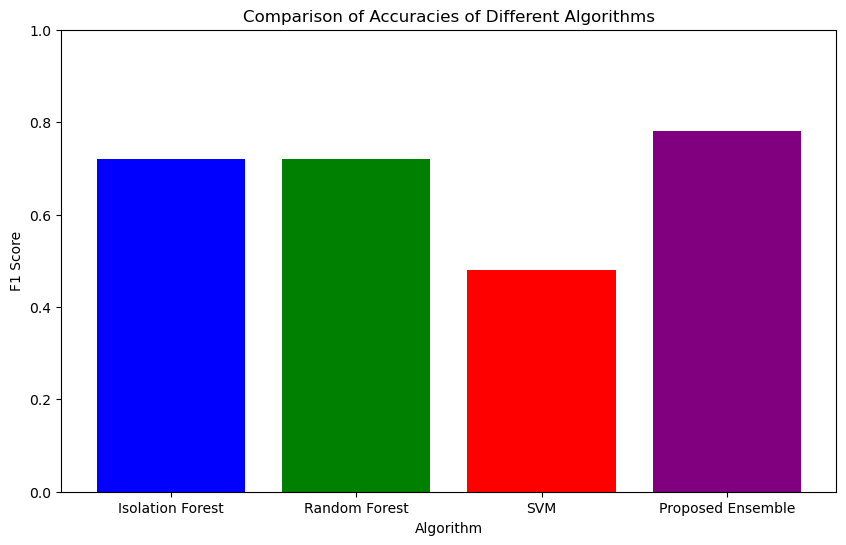

In [48]:
# Create a list of F1 scores
f1_scores = [if_f1_score, rf_f1_score, svm_f1_score, ensemble_f1_score]
labels = ['Isolation Forest', 'Random Forest', 'SVM', 'Proposed Ensemble']

# Plotting the F1 scores
plt.figure(figsize=(10, 6))
plt.bar(labels, f1_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Algorithm')
plt.ylabel('F1 Score')
plt.title('Comparison of Accuracies of Different Algorithms')
plt.ylim(0, 1)
plt.show()